<a href="https://colab.research.google.com/github/MahdiEsrafili/image_segmentation/blob/master/skin_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [31]:
! mkdir ~/.kaggle
% cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d nodoubttome/skin-cancer9-classesisic
!unzip -q skin-cancer9-classesisic.zip -d data/

In [11]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
from sklearn.metrics import classification_report
import random
%matplotlib inline

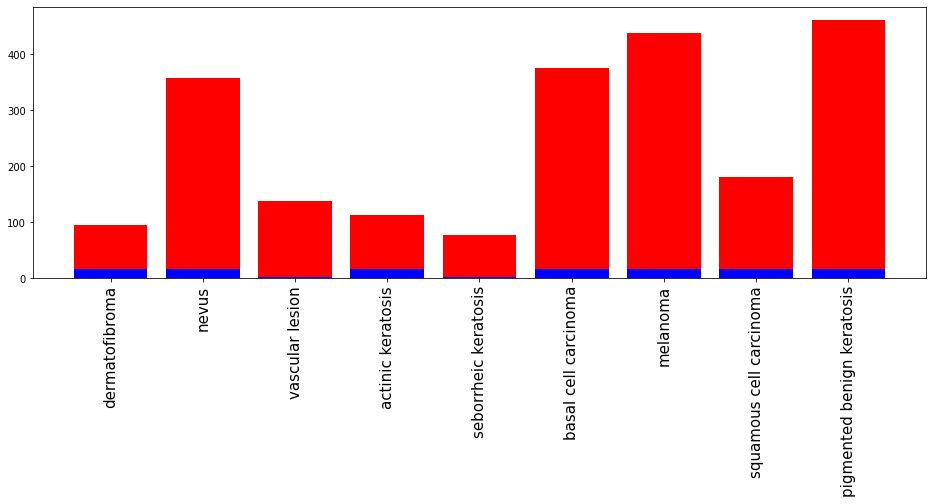

In [32]:
path = '/content/data/Skin cancer ISIC The International Skin Imaging Collaboration'
branches = ['Test', 'Train']
distributions = dict()
for branch in branches:
  diseases = dict()
  for disease in os.listdir(os.path.join(path, branch)):
    diseases[disease] = len(os.listdir(os.path.join(path, branch, disease)))
  distributions[branch] = diseases

plt.figure(figsize=(16, 5))
plt.bar(distributions['Train'].keys(), distributions['Train'].values(), color='r')
plt.bar(distributions['Test'].keys(), distributions['Test'].values(), color='b')
plt.xticks(rotation = 90, fontsize=15) # Rotates X-Axis Ticks by 45-degrees
plt.show()


In [5]:
distributions

{'Test': {'actinic keratosis': 16,
  'basal cell carcinoma': 16,
  'dermatofibroma': 16,
  'melanoma': 16,
  'nevus': 16,
  'pigmented benign keratosis': 16,
  'seborrheic keratosis': 3,
  'squamous cell carcinoma': 16,
  'vascular lesion': 3},
 'Train': {'actinic keratosis': 114,
  'basal cell carcinoma': 376,
  'dermatofibroma': 95,
  'melanoma': 438,
  'nevus': 357,
  'pigmented benign keratosis': 462,
  'seborrheic keratosis': 77,
  'squamous cell carcinoma': 181,
  'vascular lesion': 139}}

We can infer from distribution that data is unbalanced, so we duplicate the images using transforms to make disribution equal.

In [6]:
import torchvision
import torch
from torchvision import transforms as T
from torch import nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [7]:
train_transforms = T.Compose([
                        T.Resize((224, 224)),
                        T.RandomVerticalFlip(0.3),
                        T.RandomHorizontalFlip(0.3),
                        T.ToTensor(),
                        T.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])
])

test_transforms = T.Compose([
                        T.Resize((224, 224)),
                        T.ToTensor(),
                        T.Normalize(mean = [0.485, 0.456, 0.406],
                                    std = [0.229, 0.224, 0.225])
])

# augmentation part

In [10]:
max(list(distributions['Train'].values()))

462

In [33]:
def augment(path, transforms, max_number=462):
  images = os.listdir(path)
  count = len(images)
  diff = max_number - count
  for i in range(diff):
    img_id = random.sample(images, 1)[0]
    img_path = os.path.join(path, img_id)
    img = Image.open(img_path)
    img = transforms(img)
    img.save(os.path.join(path, f'aug{random.randint(0, 1e5)}_{img_id}'))
  print(f'augmentation {path} done with {diff} samples')

aug_transforms = T.Compose([
                            T.RandomRotation(45),
                            T.RandomVerticalFlip(),
                            T.RandomHorizontalFlip()
])

path = '/content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
train_dirs = os.listdir(path)
for d in train_dirs:
   augment(os.path.join(path, d), aug_transforms)

augmentation /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma done with 367 samples
augmentation /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus done with 105 samples
augmentation /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion done with 323 samples
augmentation /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis done with 348 samples
augmentation /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis done with 385 samples
augmentation /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma done with 86 samples
augmentation /content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma done with 24 samples
augmentation /content/data/Skin cancer ISIC The International Skin Imaging Co

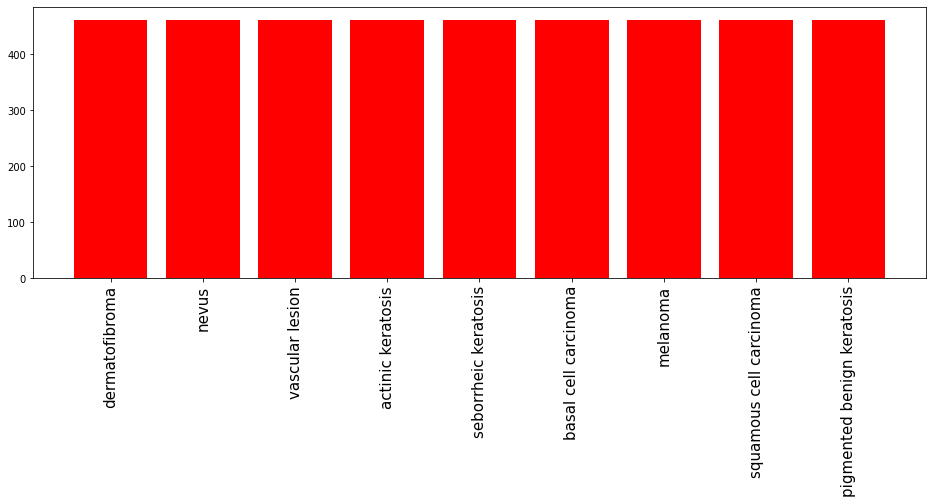

In [34]:
path = '/content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
distributions = dict()
for disease in os.listdir(path):
  distributions[disease] = len(os.listdir(os.path.join(path, disease)))

plt.figure(figsize=(16, 5))
plt.bar(distributions.keys(), distributions.values(), color='r')
plt.xticks(rotation = 90, fontsize=15) # Rotates X-Axis Ticks by 45-degrees
plt.show()


In [35]:
distributions

{'actinic keratosis': 462,
 'basal cell carcinoma': 462,
 'dermatofibroma': 462,
 'melanoma': 462,
 'nevus': 462,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 462,
 'squamous cell carcinoma': 462,
 'vascular lesion': 462}

In [37]:
path

'/content/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train'

In [38]:
path = '/content/data/Skin cancer ISIC The International Skin Imaging Collaboration'
train_dataset = torchvision.datasets.ImageFolder(os.path.join(path, 'Train'), 
                                                 transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(os.path.join(path, 'Test'), 
                                                 transform=test_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [40]:
# from functools import reduce
# reduce(lambda x,y: x+y, distributions['Train'].values())

In [41]:
# total_samples = 2239
# weights_named = {k:v/total_samples for (k,v) in distributions['Train'].items()}
# weights_named

In [42]:
# weights = dict()
# for k, v in train_loader.dataset.class_to_idx.items():
#   weights[v] = weights_named[k]
# weights

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [44]:
model = torchvision.models.resnet18(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [45]:
num_classes = 9
model.fc = nn.Linear(model.fc.in_features, num_classes)
torch.nn.init.xavier_uniform_(model.fc.weight);
model = model.to(device)

In [46]:
# param_group = True
lr = 1e-3
# if param_group:
#     params_1x = [param for name,param in model.named_parameters()
#                 if name not in ['fc.weight','fc.bias']]
#     optimizer = torch.optim.SGD([{'params':params_1x},
#                                {'params':model.fc.parameters(), 'lr':0.001}],
#                              lr=lr, weight_decay=0.001)
# else:
#     optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# loss_weights = torch.tensor(list(weights.values()))
# criterion = nn.CrossEntropyLoss(weight=loss_weights).to(device)
criterion = nn.CrossEntropyLoss().to(device)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [47]:
def train(model, trainset, criterion, optimizer, lr_scheduler, num_epochs=10, batch_size=32):
  loss_history = list()
  for epoch in range(num_epochs):
    model.train()
    train_size = int(0.9*len(trainset))
    valid_size = len(trainset) - train_size
    train_ds, valid_ds = torch.utils.data.random_split(trainset, [train_size, valid_size],
                 generator=torch.Generator().manual_seed(42))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)
    pbar = tqdm(train_loader)
    epoch_losses = np.array([])
    train_corrects = 0
    train_img_passed = 0
    for images, labels in pbar:
      images = images.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      out = model(images)
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()
      pred = out.argmax(dim=1).cpu().numpy()
      train_corrects += (pred==labels.cpu().numpy()).sum()
      train_img_passed += pred.shape[0]
      train_accuracy = train_corrects/train_img_passed
      epoch_losses = np.append(epoch_losses, loss.item())
      pbar.set_description(f'epoch {epoch+1}/{num_epochs},\
                            accuracy={train_accuracy:.4f}, error={epoch_losses.mean():.4f} ')
    loss_history.append(epoch_losses.mean())
    lr_scheduler.step()
    with torch.no_grad():
      model.eval()
      valid_corrects = 0
      valid_loss = np.array([])
      for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out = model(images)
        pred = out.argmax(dim=1).cpu().numpy()
        valid_corrects += (pred==labels.cpu().numpy()).sum()
        loss = criterion(out, labels)
        valid_loss = np.append(valid_loss, loss.item())
      valid_accuracy = valid_corrects/len(valid_ds)
      valid_loss = valid_loss.mean()
      print(f'val accuracy = {valid_accuracy:.4f}, val loss ={valid_loss:.4f}')
  return model, loss_history


In [48]:
model, loss_history = train(model, train_dataset, criterion, optimizer, lr_scheduler, num_epochs=30)


val accuracy = 0.5144, val loss =1.2681



val accuracy = 0.6587, val loss =1.1083



val accuracy = 0.7115, val loss =0.8627



val accuracy = 0.6587, val loss =0.9377



val accuracy = 0.7212, val loss =0.7300



val accuracy = 0.7548, val loss =0.6701



val accuracy = 0.7043, val loss =0.7950



val accuracy = 0.7452, val loss =0.6483



val accuracy = 0.7332, val loss =0.8228



val accuracy = 0.7091, val loss =0.8754



val accuracy = 0.8173, val loss =0.4850



val accuracy = 0.8077, val loss =0.4756



val accuracy = 0.8005, val loss =0.4803



val accuracy = 0.8053, val loss =0.4768



val accuracy = 0.8173, val loss =0.4601



val accuracy = 0.8245, val loss =0.4769



val accuracy = 0.8365, val loss =0.4410



val accuracy = 0.8317, val loss =0.4378



val accuracy = 0.8125, val loss =0.4697



val accuracy = 0.8149, val loss =0.5438



val accuracy = 0.8005, val loss =0.4856



val accuracy = 0.8197, val loss =0.4806



val accuracy = 0.8125, val loss =0.5355



val accuracy = 0.8293, val loss =0.4736



val accuracy = 0.8197, val loss =0.5281



val accuracy = 0.8317, val loss =0.4759



val accuracy = 0.8197, val loss =0.5359



val accuracy = 0.8293, val loss =0.5097



val accuracy = 0.8413, val loss =0.4762



val accuracy = 0.8317, val loss =0.4909


In [49]:
with open('/content/model.pt', 'wb') as f:
  torch.save(model , f)
!cp /content/model.pt /content/drive/MyDrive/skin_cancer/

In [63]:

def test(model, dataloaders, criterion):
  with torch.no_grad():
    all_preds = np.array([])
    ground_truth = np.array([])
    losses = 0
    model.eval()
    for (images, labels) in dataloaders:
      images = images.to(device)
      labels = labels.to(device)
      preds = model(images)
      loss = criterion(preds, labels)
      preds = preds.argmax(axis=1)
      all_preds = np.append(all_preds, preds.cpu().numpy().astype(int))
      ground_truth = np.append(ground_truth, labels.cpu().numpy().astype(int))
      losses +=  loss.item()
  print(losses/ground_truth.shape[0])
  target_names = [k for k,v in train_loader.dataset.class_to_idx.items()]
  print(classification_report(ground_truth.astype(np.int16), all_preds.astype(np.int16), target_names=target_names))

In [64]:
test(model, test_loader, criterion)

0.08878846542309907
                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.64      0.88      0.74        16
            dermatofibroma       0.83      0.62      0.71        16
                  melanoma       0.11      0.06      0.08        16
                     nevus       0.37      0.94      0.53        16
pigmented benign keratosis       0.65      0.81      0.72        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.80      0.50      0.62        16
           vascular lesion       1.00      1.00      1.00         3

                  accuracy                           0.54       118
                 macro avg       0.49      0.53      0.49       118
              weighted avg       0.49      0.54      0.49       118



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
